# Sensitivity of a counting experiment

## Objetives

* **Estimate the sensitivity of the counting experiment**

* Given a number of bkg events in the RoI what is the most probable limit that we impose in the $\mathcal{T}_{1/2}^{\beta\beta0\nu}$ in the case of no signal.

## Analysis

#### Importing modules

In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [32]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
rootpath = os.getcwd()[:-15]
print('add path to PYTHONPATH : ', rootpath)
sys.path.insert(0, os.path.abspath(rootpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/


In [33]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.confint as confint  # Confidence Intervals 
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

### The half-time relation 

The relation of the $\mathcal{T}_{1/2}^{\beta\beta0\nu}$ with the number of estimated signal events $n^{\beta\beta}_{RoI}$ in the RoI is:

$$
\mathcal{T}_{1/2}^{\beta\beta2\nu} = \frac{\delta \, \epsilon^{\beta\beta}_{RoI} \, M \, t }{n^{\beta\beta}_{RoI}} \frac{N_A \, \log(2)}{W}
$$

Where:

  * $\delta$ is the abundance of the $^{136}\mathrm{Xe}$ among other $\mathrm{Xe}$ isotopes (in our experiment 0.9)
  * $\epsilon^{\beta\beta}_E$ is the efficiency of selecting signal events in the E window (in fraction, computed using the mc)
  * $M$ the mass of the detector (g)
  * $t$ the time of the exposure (y)
  * $N_A$ is the Avogadro number
  * $W$ is the atomic mass in (g)

## Main parameters

In [34]:
collaboration = collpars.collaboration
sel_ntracks   = collpars.sel_ntracks
sel_eblob2    = collpars.sel_eblob2
sel_erange    = collpars.sel_erange
sel_eroi      = collpars.sel_eroi

n_Bi_E        = collpars.n_Bi_E
n_Tl_E        = collpars.n_Tl_E
n_Bi_RoI      = collpars.n_Bi_RoI
n_Tl_RoI      = collpars.n_Tl_RoI


print('Collaboration             : {:s}'.format(collaboration))

Collaboration             : new_beta


### Data

In [35]:
### data

# set the path to the data directory and filenames
dirpath = rootpath+'/data/'
filename = 'fanal_' + collaboration + '.h5'
print('Data path and filename : ', dirpath + filename)

# access the simulated data (DataFrames) for the different samples (Bi, Tl, bb) located in the data file
mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

# set the names of the samples
# set the names of the samples
mc_samples         = [mcbi, mctl, mcbb] # list of the mc DFs
sample_names       = ['Bi', 'Tl', 'bb']
sample_names_latex = [ r'$^{214}$Bi', r'$^{208}$Tl', r'$\beta\beta0\nu$',] # str names of the mc samples

for i, mc in enumerate(mc_samples):
    print('MC Sample {:s}, number of simulated events = {:d}'.format(sample_names[i], len(mc)))

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2//data/fanal_new_beta.h5
MC Sample Bi, number of simulated events = 60184
MC Sample Tl, number of simulated events = 687297
MC Sample bb, number of simulated events = 47636


### Conficence Intervals

The frenquentist intervals are usually computed using the Feldman-Cousin construction.
  
The following code constract the confidence bands for a given number of *observed* events (in the *x* axis) and a range on the number of *true signal events* ( in the *y* axis).



**Exercise**:

  * Study how the CI changes depending on the number of observed events
  
  * Study what is the value of observed events that will give an observation and a discovery.

In [36]:
nbkg   = n_Bi_RoI + n_Tl_RoI
n0     = int(nbkg)      # number of observed events (int)
cls    = (0.68, 0.90, 0.95)    # range of CL to show
factor = 1.5
nbins  = 100
nus    = np.linspace(0., factor * nbkg, 100) # range of number of signal events

# get the FC-CI functions for 68% and 95% CL
fcs    = [confint.get_fc_confinterval(nus, nbkg, cl = cl) for cl in cls]

for fc, cl in zip(fcs, cls):
    ci = fc(n0)
    print('FC Cover Interval, observed n = {:d}, at {:2.0f} % CL = ({:4.2f}, {:4.2f})'.format(n0, 100*cl, *ci))

FC Cover Interval, observed n = 25, at 68 % CL = (0.00, 4.69)
FC Cover Interval, observed n = 25, at 90 % CL = (0.00, 8.59)
FC Cover Interval, observed n = 25, at 95 % CL = (0.00, 10.55)


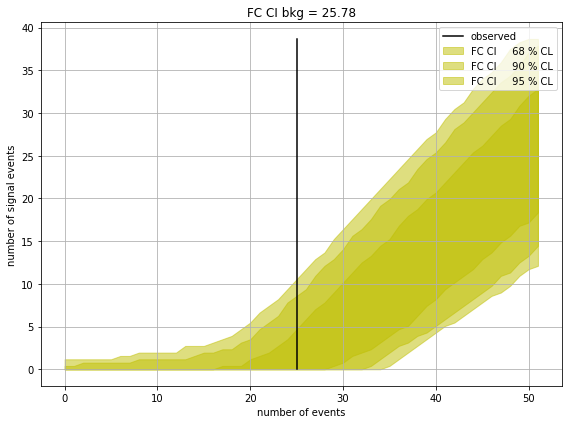

In [37]:
# plot the conficence band and the segment associated to an observation
pltext.canvas(1, 1, 6, 8)
ns   = np.arange(0, 2 * nbkg)
for fc, cl in zip(fcs, cls):    
    ys   = fc(ns)
    plt.fill_between(ns, *ys, alpha = 0.5, color = 'y', label = 'FC CI {:6.0f} % CL'.format(100*cl))
plt.plot(n0 * np.ones(len(nus)), nus, label = 'observed')
plt.legend(); plt.grid(which = 'both');
plt.title('FC CI bkg = {:4.2f}'.format(nbkg));
plt.xlabel('number of events'); plt.ylabel('number of signal events');
plt.tight_layout();

Translate the number of signal events into half-life time.

**Exsercise** Implement the *tau* function to return the lifetime assocaited to *nbb* events in the selected RoI.

In [38]:
def tau(nbb):
    eff      = collpars.eff_bb_RoI
    exposure = collpars.exposure
    tau      = nbb/collpars.exposure # implement here the formula of the lifetime
    return tau

In [39]:
for fc, cl in zip(fcs, cls):
    ci   = fc(n0)
    taus = [tau(x) for x in ci]
    taus.reverse()
    print('FC Cover Interval, observed n = {:d}, at {:2.0f} % CL = ({:4.2e}, {:4.2e})'.format(n0, 100*cl, *taus))

FC Cover Interval, observed n = 25, at 68 % CL = (4.69e-03, 0.00e+00)
FC Cover Interval, observed n = 25, at 90 % CL = (8.59e-03, 0.00e+00)
FC Cover Interval, observed n = 25, at 95 % CL = (1.05e-02, 0.00e+00)


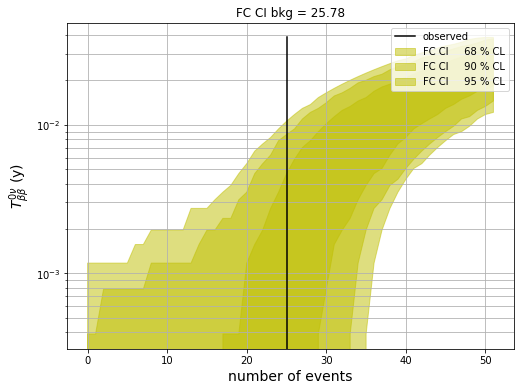

In [40]:
pltext.canvas(1, 1, 6, 8)
for fc, cl in zip(fcs, cls):    
    ys     = fc(ns)
    taus   = tau(ys)
    taus[taus == np.inf] = tau(nus[1])
    plt.fill_between(ns, *taus, 
                     alpha = 0.5, color = 'y', label = 'FC CI {:6.0f} % CL'.format(100*cl))
plt.plot(n0 * np.ones(len(nus)), tau(nus), label = 'observed')
plt.legend(); plt.grid(which = 'both');
plt.title('FC CI bkg = {:4.2f}'.format(nbkg));
plt.xlabel('number of events', fontsize = 14); plt.ylabel(r'$T^{0\nu}_{\beta\beta}$ (y)', fontsize = 14);
plt.yscale('log');
#plt.tight_layout();

### Compute p-value of null hypothesis


The p-value is the probability to obtain an experiment with a agreemen with no-signal equal to the observation or worse.

When the p-value of the null-hypotehsis is > 3 sigmas, we claim an eividende, when the p-valyes is > 5 sigmas, a discovery!

Note that we claim a discovery when data does not agree with the hypothesis of only background!

In the case of the counting experiment the distribution of number of observed events in the case of no signal is a Poisson distribution with mean $n^{bkg}_{RoI}$, the number of background events in the RoI

In [41]:
Z3    = 0.0027  # 3-sigma
Z5    = 2.87e-7 # 5-sigma
p0 = stats.poisson.sf(ns, nbkg) 

for z in (Z3, Z5):
    if (np.min(p0) < z):
        n1 = int(np.min(ns[p0<z]))
        print('p0-values < {:1.2e} if n > {:d}, Tbb < {:1.2e} y'.format(z, n1, tau(n1)))

p0-values < 2.70e-03 if n > 41, Tbb < 4.10e-02 y


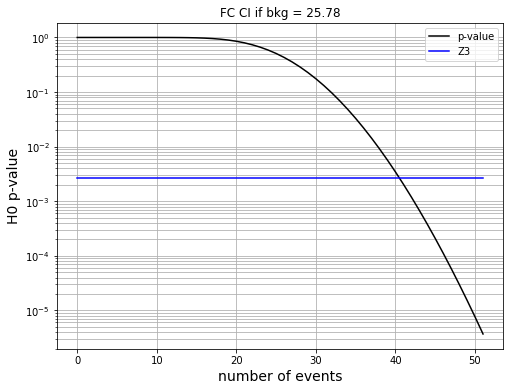

In [42]:
pltext.canvas(1, 1, 6, 8)
p0 = stats.poisson.sf(ns, nbkg) 
plt.plot(ns, p0, label = 'p-value')
plt.plot(ns, Z3 * np.ones(len(ns)), label = 'Z3')
plt.title('FC CI if bkg = {:4.2f}'.format(nbkg));
plt.xlabel('number of events', fontsize = 14); plt.ylabel(r'H0 p-value', fontsize = 14);
plt.yscale('log'); plt.grid(which = 'both'); plt.legend();